In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely.geometry
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'

In [3]:
site_1 = {
    'name': "Williamsburg Bridge",
    'before_start' : '2016-11-21',
    'before_end' : '2017-11-21',
    'after_start' : '2017-11-22',
    'after_end' : '2018-11-22'
}

In [4]:
site = site_1

In [5]:
zone = site['name']
before_start = site['before_start']
before_end = site['before_end']
after_start = site['after_start']
after_end = site['after_end']

In [6]:
stations_df = pd.read_csv(f'{EXPORTS_DIR}/station_snapshots/{zone}/stations_in_timeperiod.csv')
stations_df['date'] = stations_df['date'].astype(str)
station_ids = stations_df['id'].unique()
len(station_ids)

481

In [7]:
zips = gpd.read_file(f'{DATA_DIR}/geo/zip_code/zip_code.shp')
zips = zips.to_crs(CRS_LATLON)
zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [8]:
##define zips for analysis
zipsMN = ['10003', '10009', '10010', '10011', '10014']
zipsBK = ['11206', '11211', '11237', '11385']

In [9]:
zips_1 = zips.loc[(zips.ZIPCODE.isin(zipsMN)==True)].copy()
zips_2 = zips.loc[(zips.ZIPCODE.isin(zipsBK)==True)].copy()

<AxesSubplot:>

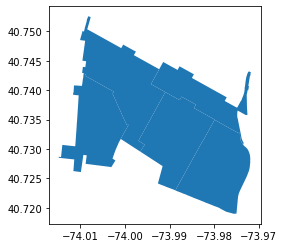

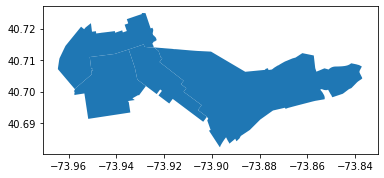

In [10]:
zips_1.plot()
zips_2.plot()

In [11]:
#station_coords = pd.read_csv(f'{EXPORTS_DIR}/station_coords.csv')

In [12]:
stations_df.head()

,Unnamed: 0,id,date,lat,lon,geometry,ct2010,boro_code
0,0,116,201310,40.741776,-74.001497,POINT (-74.00149746 40.74177603),8300,1
1,1,212,201310,40.743349,-74.006818,POINT (-74.00681753000001 40.74334935),8300,1
2,2,434,201310,40.743174,-74.003664,POINT (-74.00366443 40.74317449),8300,1
3,3,463,201310,40.742065,-74.004432,POINT (-74.00443172 40.74206539),8300,1
4,4,119,201310,40.696089,-73.978034,POINT (-73.97803415 40.69608941),2901,3


In [13]:
#geometry = [Point(xy) for xy in zip(station_coords.lon, station_coords.lat)]
#stations_geo = GeoDataFrame(station_coords, crs="EPSG:4326", geometry=geometry)

In [14]:
geometry = [Point(xy) for xy in zip(stations_df.lon, stations_df.lat)]
stations_geo = GeoDataFrame(stations_df, crs="EPSG:4326", geometry=geometry)

In [15]:
#stations_of_interest = gpd.sjoin(zips_of_int, stations_geo, op='intersects', how='inner')
#stations_of_interest.head()

In [16]:
stationsgeo_1 = gpd.sjoin(zips_1, stations_geo, predicate='intersects', how='inner')
stationsgeo_2 = gpd.sjoin(zips_2, stations_geo, predicate='intersects', how='inner')

<AxesSubplot:>

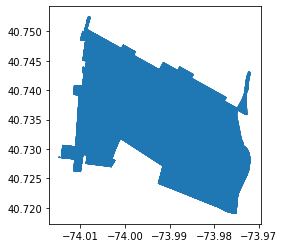

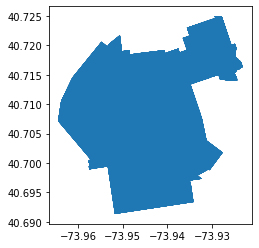

In [17]:
stationsgeo_1.plot()
stationsgeo_2.plot()

In [18]:
YEAR_STRINGS = [str(y) for y in range(2017, 2018)]
MONTH_STRINGS = [f'{m:02d}' for m in range(1, 13)]

MONTH_2016_STRINGS = [f'{m:02d}' for m in range(11, 13)]
MONTH_2018_STRINGS = [f'{m:02d}' for m in range(1, 12)]

DATE_STRINGS = (
    [f'2016{m}' for m in MONTH_2016_STRINGS] +
    [f'{y}{m}' for y in YEAR_STRINGS for m in MONTH_STRINGS] +
    [f'2018{m}' for m in MONTH_2018_STRINGS]

)
print(DATE_STRINGS)

['201611', '201612', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712', '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811']


In [19]:
dfs = []
column_names = ['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender']
for date in DATE_STRINGS:
    filename_csv = f'{DATA_DIR}/citibike/csv/{date}-citibike-tripdata.csv'
    #print(filename_csv)
    df = pd.read_csv(filename_csv)
    df.columns = column_names
    dfs.append(df)

In [20]:
citibike = pd.concat(dfs)
citibike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,331,2016-11-01 00:00:08,2016-11-01 00:05:40,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,419.0,Carlton Ave & Park Ave,40.695807,-73.973556,21959,Subscriber,1981.0,1
1,740,2016-11-01 00:00:08,2016-11-01 00:12:29,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,265.0,Stanton St & Chrystie St,40.722293,-73.991475,20172,Subscriber,1991.0,1
2,229,2016-11-01 00:00:11,2016-11-01 00:04:00,3074.0,Montrose Ave & Bushwick Ave,40.707678,-73.940162,3068.0,Humboldt St & Varet St,40.703172,-73.940636,22995,Subscriber,1984.0,1
3,155,2016-11-01 00:00:18,2016-11-01 00:02:53,3357.0,W 106 St & Amsterdam Ave,40.800836,-73.966449,3323.0,W 106 St & Central Park West,40.798186,-73.960591,22022,Subscriber,1973.0,1
4,772,2016-11-01 00:00:23,2016-11-01 00:13:15,346.0,Bank St & Hudson St,40.736529,-74.006180,432.0,E 7 St & Avenue A,40.726218,-73.983799,17324,Subscriber,1988.0,1


In [21]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id           float64
start station name          object
start station latitude     float64
start station longitude    float64
end station id             float64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

In [22]:
# Split into stations based on the two different zones
stations1 = (pd.to_numeric(stationsgeo_1['id'], errors = 'coerce')).values
stations2 = (pd.to_numeric(stationsgeo_2['id'], errors = 'coerce')).values

In [23]:
#backup = citibike
#citibike = backup

In [24]:
# Filter to trips that start in the first zone and end in the second, or vice versa
citibike = citibike.loc[((citibike['start station id'].isin(stations1)==True) & (citibike['end station id'].isin(stations2)==True))| \
                       ((citibike['start station id'].isin(stations2)==True) & (citibike['end station id'].isin(stations1)==True))].copy()

In [25]:
citibike['Timestamp'] = pd.to_datetime(citibike.starttime, errors='coerce')
citibike['Date'] = citibike.Timestamp.dt.date
citibike['Count'] = np.zeros(len(citibike))

In [26]:
citibike['Age'] = ((datetime.strptime(before_end, '%Y-%m-%d')).year) - (citibike['birth year'])

In [30]:
#Split our citi bike trips into the two time periods
cb_pre = citibike.loc[(citibike.starttime < after_start)].copy()
cb_post = citibike.loc[(citibike.starttime > after_start)].copy()

In [31]:
#Update the age for the after portion - assume everyone is one year older
cb_post['Age'] = (cb_post['Age'] +1).copy()

In [32]:
cb_post.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Timestamp,Date,Count,Age
998368,1473,2017-11-22 00:04:59,2017-11-22 00:29:32,285.0,Broadway & E 14 St,40.734546,-73.990741,532.0,S 5 Pl & S 4 St,40.710451,-73.960876,26550,Customer,NaN,0,2017-11-22 00:04:59,2017-11-22,0.0,NaN
998376,1404,2017-11-22 00:05:46,2017-11-22 00:29:10,285.0,Broadway & E 14 St,40.734546,-73.990741,532.0,S 5 Pl & S 4 St,40.710451,-73.960876,15258,Customer,NaN,0,2017-11-22 00:05:46,2017-11-22,0.0,NaN
998539,2683,2017-11-22 00:29:02,2017-11-22 01:13:45,483.0,E 12 St & 3 Ave,40.732233,-73.988900,532.0,S 5 Pl & S 4 St,40.710451,-73.960876,15711,Customer,NaN,0,2017-11-22 00:29:02,2017-11-22,0.0,NaN
998540,2664,2017-11-22 00:29:06,2017-11-22 01:13:31,483.0,E 12 St & 3 Ave,40.732233,-73.988900,532.0,S 5 Pl & S 4 St,40.710451,-73.960876,32118,Customer,NaN,0,2017-11-22 00:29:06,2017-11-22,0.0,NaN
998575,1494,2017-11-22 00:34:29,2017-11-22 00:59:24,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3061.0,Throop Ave & Myrtle Ave,40.696229,-73.943711,27362,Subscriber,1987.0,1,2017-11-22 00:34:29,2017-11-22,0.0,31.0


In [33]:
len(stations1), len(stations2)

(80, 39)

In [34]:
print(len(cb_pre['start station id'].unique()))
print(len(cb_post['start station id'].unique()))
print(len(citibike['start station id'].unique()))

114
104
114


In [35]:
# Aggregate by date
cb_pre_daily =  cb_pre.groupby('Date').agg({'Count':'count'})
cb_post_daily =  cb_post.groupby('Date').agg({'Count':'count'})

In [36]:
cb_pre_daily = cb_pre_daily.reset_index()
cb_post_daily = cb_post_daily.reset_index()
cb_pre_daily['Date']  = pd.to_datetime(cb_pre_daily['Date']).copy()
cb_post_daily['Date']  = pd.to_datetime(cb_post_daily['Date']).copy()

In [37]:
cb_pre_daily = cb_pre_daily.loc[(cb_pre_daily.Date > (datetime.strptime(before_start, '%Y-%m-%d')))]
cb_post_daily = cb_post_daily.loc[(cb_post_daily.Date < (datetime.strptime(after_end, '%Y-%m-%d')))]

In [38]:
# Check start and end date ranges
print(cb_pre_daily[['Date']].head(1), cb_pre_daily[['Date']].tail(1))
print(cb_post_daily[['Date']].head(1), cb_post_daily[['Date']].tail(1))

         Date
21 2016-11-22           Date
381 2017-11-21
        Date
0 2017-11-22           Date
362 2018-11-21


In [39]:
cb_pre_daily['DayOfYear'] = cb_pre_daily['Date'].dt.strftime('%m-%d')
cb_pre_daily = cb_pre_daily[['Count', 'DayOfYear']].set_index('DayOfYear')
cb_post_daily['DayOfYear'] = cb_post_daily['Date'].dt.strftime('%m-%d')
cb_post_daily = cb_post_daily[['Count', 'DayOfYear']].set_index('DayOfYear')

In [40]:
cb_pre_daily.columns = ['CountBefore']
cb_post_daily.columns = ['CountAfter']

In [41]:
cb_post_daily.head()


,CountAfter
DayOfYear,
11-22,40
11-23,22
11-24,31
11-25,58
11-26,47


In [42]:
# Set up a new df to compare on the same date for both years
cb_compare = pd.merge(cb_pre_daily, cb_post_daily, on = 'DayOfYear',how = "inner") 

In [43]:
cb_compare

,CountBefore,CountAfter
DayOfYear,,
11-22,39,40
11-23,41,22
11-24,24,31
11-25,37,58
11-26,62,47
...,...,...
11-17,67,95
11-18,50,76
11-19,64,80


In [44]:
date_series = pd.Series(cb_compare.index.values)
before_series = pd.Series(cb_compare.CountBefore.values)
after_series = pd.Series(cb_compare.CountAfter.values)

Text(0.5, 1.0, 'Ridership Over Williamsburg Bridge Before and After Bike Lane Enhancement')

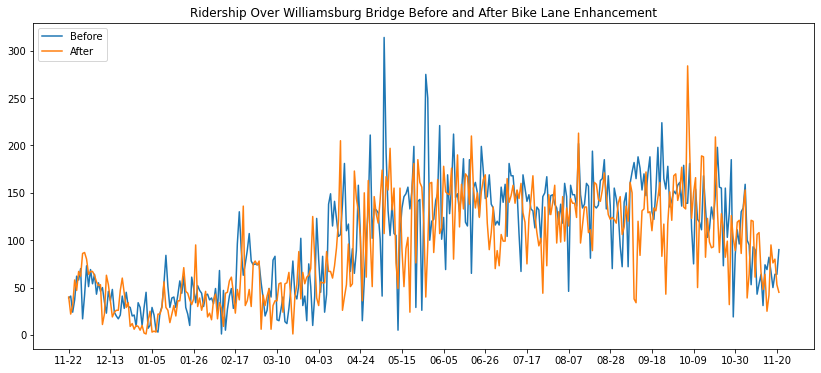

In [45]:
import matplotlib.ticker as plticker
#Raw timeseries before and after
fig, ax = plt.subplots(figsize=(14,6))
loc = plticker.MultipleLocator(base=21) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(date_series, before_series, label = 'Before')
ax.plot(date_series, after_series, label = 'After')
ax.legend(loc='upper left')
ax.set_title(f'Ridership Over {zone} Before and After Bike Lane Enhancement')

Text(0.5, 1.0, 'Ridership Over Williamsburg Bridge Before and After 2017-11-21 Bike Lane Enhancement')

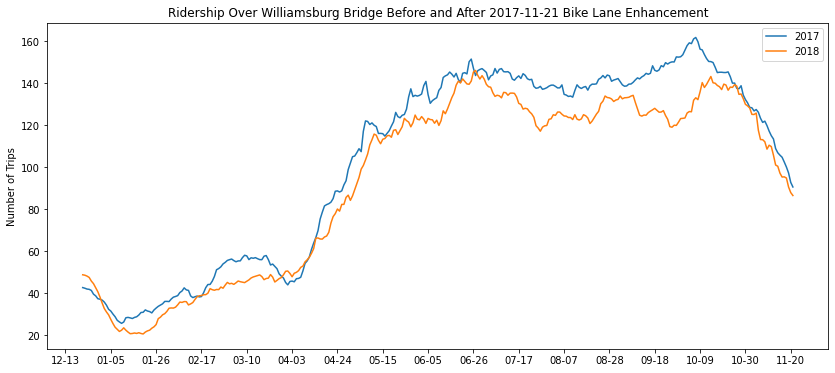

In [79]:
#Smooth with rolling average
fig, ax = plt.subplots(figsize=(14,6))
loc = plticker.MultipleLocator(base=21) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(date_series, before_series.rolling(window =30).mean(), label = 2017)
ax.plot(date_series, after_series.rolling(window = 30).mean(), label = 2018)
ax.set_ylabel('Number of Trips')
ax.legend(loc='upper right')
ax.set_title(f'Ridership Over {zone} Before and After 2017-11-21 Bike Lane Enhancement')

In [51]:
result = adfuller(before_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.379562
p-value: 0.592034
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [52]:
result = adfuller(after_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.058871
p-value: 0.261371
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [53]:
full_series = pd.concat([before_series, after_series])

In [54]:
result = adfuller(full_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.873511
p-value: 0.344623
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [55]:
first_diff = full_series.diff().dropna()
result = adfuller(first_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.084205
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [56]:
before_diff = before_series.diff().dropna() #=first_diff[:(len(before_series))]
after_diff = after_series.diff().dropna() #=first_diff[:(len(after_series))]

Text(0.5, 1.0, 'Ridership +1st Order Differenceing Over Williamsburg Bridge Before and After Bike Lane Enhancement')

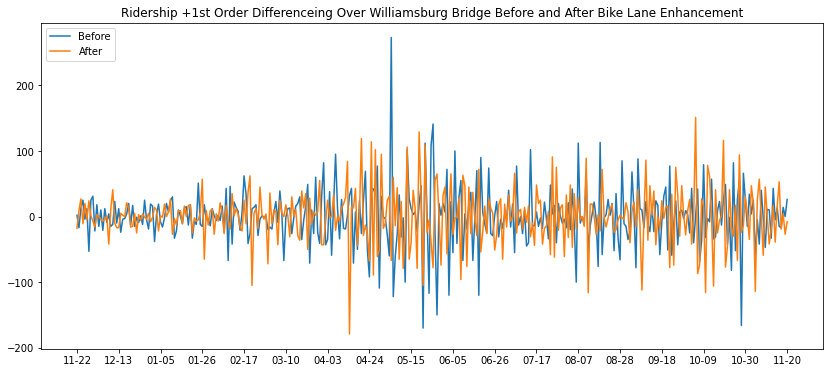

In [58]:
fig, ax = plt.subplots(figsize=(14,6))
loc = plticker.MultipleLocator(base=21) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(date_series[:(len(before_diff))], before_diff, label = 'Before')
ax.plot(date_series[:(len(before_diff))], after_diff, label = 'After')
ax.legend(loc='upper left')
ax.set_title(f'Ridership +1st Order Differenceing Over {zone} Before and After Bike Lane Enhancement')

Text(0.5, 1.0, 'Ridership +1st Order Differenceing +Rolling Avg Over Williamsburg Bridge Before and After Bike Lane Enhancement')

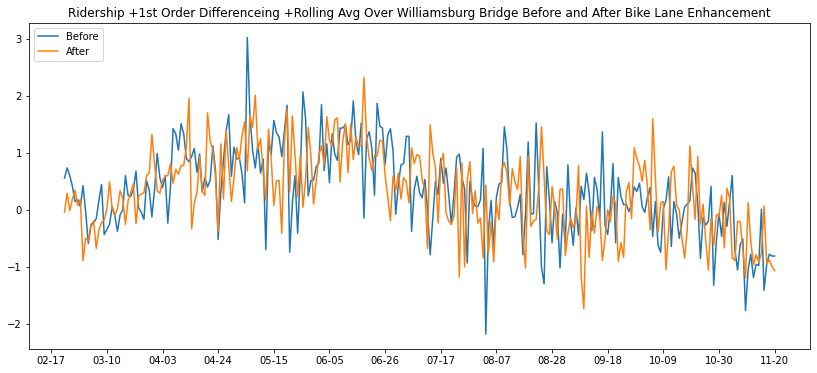

In [59]:
fig, ax = plt.subplots(figsize=(14,6))
loc = plticker.MultipleLocator(base=21) # this locator puts ticks at regular intervals
ax.xaxis.set_ticks(before_diff.index)
ax.xaxis.set_major_locator(loc)
ax.plot(date_series[:(len(before_diff))], before_diff.rolling(window = 90).mean(), label = 'Before')
ax.plot(date_series[:(len(before_diff))], after_diff.rolling(window = 90).mean(), label = 'After')
ax.legend(loc='upper left')
ax.set_title(f'Ridership +1st Order Differenceing +Rolling Avg Over {zone} Before and After Bike Lane Enhancement')

In [60]:
sum(cb_pre_daily.CountBefore)

36000

In [61]:
sum(cb_post_daily.CountAfter)

33122

## Run again but count gender breakdown as well

In [ ]:
cb_pre = citibike.loc[(citibike.starttime < after_start)].copy()
cb_post = citibike.loc[(citibike.starttime > after_start)].copy()

In [ ]:
gender_pre_daily =  cb_pre.groupby(['Date', 'gender']).agg({'Count':'count'})
gender_post_daily =  cb_post.groupby(['Date', 'gender']).agg({'Count':'count'})

In [ ]:
gender_pre_daily = gender_pre_daily.reset_index()
gender_post_daily = gender_post_daily.reset_index()
gender_pre_daily['Date']  = pd.to_datetime(gender_pre_daily['Date']).copy()
gender_post_daily['Date']  = pd.to_datetime(gender_post_daily['Date']).copy()

In [ ]:
gender_pre_daily = gender_pre_daily.loc[(gender_pre_daily.Date > (datetime.strptime(before_start, '%Y-%m-%d')))]
gender_post_daily = gender_post_daily.loc[(gender_post_daily.Date < (datetime.strptime(after_end, '%Y-%m-%d')))]

In [ ]:
gender_pre_daily = gender_pre_daily.pivot(index = 'Date', columns = 'gender', values = 'Count').dropna()
gender_post_daily = gender_post_daily.pivot(index = 'Date', columns = 'gender', values = 'Count').dropna()

In [ ]:
gender_post_daily.head()

In [ ]:
MalePre = (sum(gender_pre_daily[1].values))
MalePost = (sum(gender_post_daily[1].values))
FemalePre = (sum(gender_pre_daily[2].values)) 
FemalePost = (sum(gender_post_daily[2].values))

In [ ]:
#Plot Gender breakdown between years 1 and 2
groups = ['M', 'F']
year1 = [MalePre, FemalePre]
year2 = [MalePost,  FemalePost]

X_axis = np.arange(len(groups))

plt.bar(X_axis - 0.25, year1, 0.4, label = 'Year 1')
plt.bar(X_axis + 0.25, year2, 0.4, label = 'Year 2')
plt.title(f"Citibike Ridership By Gender over {zone} Before and After Bike Lane Enhancement")
plt.legend()
plt.xticks(X_axis, groups)
plt.show()

## Breakdown subscriber vs customer

In [63]:
cb_pre = citibike.loc[(citibike.starttime < after_start)].copy()
cb_post = citibike.loc[(citibike.starttime > after_start)].copy()

In [65]:
cb_pre.usertype.unique()

array(['Subscriber', 'Customer', nan], dtype=object)

In [66]:
type_pre_daily =  cb_pre.groupby(['Date', 'usertype']).agg({'Count':'count'})
type_post_daily =  cb_post.groupby(['Date', 'usertype']).agg({'Count':'count'})

In [67]:
type_pre_daily = type_pre_daily.reset_index()
type_post_daily = type_post_daily.reset_index()
type_pre_daily['Date']  = pd.to_datetime(type_pre_daily['Date']).copy()
type_post_daily['Date']  = pd.to_datetime(type_post_daily['Date']).copy()

In [68]:
type_pre_daily = type_pre_daily.loc[(type_pre_daily.Date > (datetime.strptime(before_start, '%Y-%m-%d')))]
type_post_daily = type_post_daily.loc[(type_post_daily.Date < (datetime.strptime(after_end, '%Y-%m-%d')))]

In [69]:
type_pre_daily.head()

,Date,usertype,Count
41,2016-11-22,Customer,1
42,2016-11-22,Subscriber,38
43,2016-11-23,Customer,3
44,2016-11-23,Subscriber,38
45,2016-11-24,Customer,3


In [70]:
type_pre_daily = type_pre_daily.pivot(index = 'Date', columns = 'usertype', values = 'Count').dropna()
type_post_daily = type_post_daily.pivot(index = 'Date', columns = 'usertype', values = 'Count').dropna()

In [71]:
type_post_daily.head()

usertype,Customer,Subscriber
Date,,
2017-11-22,6.0,34.0
2017-11-23,9.0,13.0
2017-11-24,12.0,19.0
2017-11-25,19.0,39.0
2017-11-26,2.0,45.0


In [72]:
CustPre = (sum(type_pre_daily['Customer'].values))
CustPost = (sum(type_post_daily['Customer'].values))
SubPre = (sum(type_pre_daily['Subscriber'].values)) 
SubPost = (sum(type_post_daily['Subscriber'].values))

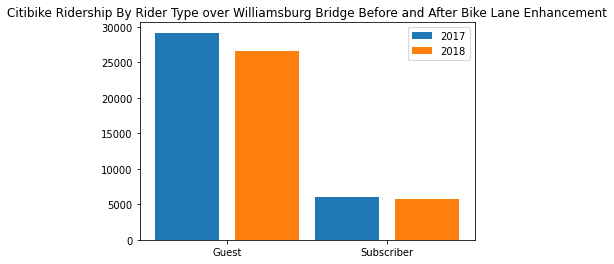

In [74]:
#Plot Gender breakdown between years 1 and 2
groups = ['Guest', 'Subscriber']
year1 = [SubPre, CustPre]
year2 = [SubPost,  CustPost]

X_axis = np.arange(len(groups))

plt.bar(X_axis - 0.25, year1, 0.4, label = '2017')
plt.bar(X_axis + 0.25, year2, 0.4, label = '2018')
plt.title(f"Citibike Ridership By Rider Type over {zone} Before and After Bike Lane Enhancement")
plt.legend()
plt.xticks(X_axis, groups)
plt.show()